# Yeni Bölüm

In [ ]:
# Hücrenin en başına koyun:
!pip install --upgrade tensorflow==2.18.0 \
    tensorflow-decision-forests==1.11.0 \
    tf-keras==2.18.0 \
    tensorflow-text==2.18.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# 1. Gerekli kütüphaneler
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
image_dir = '/content/drive/MyDrive/outputDirectory'
img_size    = (224, 224)
batch_size  = 32
random_seed = 42

In [ ]:
# 3. Görüntüleri ve (string) etiketleri topla
images = []
labels = []
for fname in os.listdir(image_dir):
    if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
        arr = img_to_array(load_img(os.path.join(image_dir, fname), target_size=img_size))
        images.append(arr)
        labels.append("sağlıklı" if '_healthy_' in fname.lower() else "sağlıksız")

In [ ]:
# 4. NumPy dizilerine dönüştür ve ölçeklendir
X = np.array(images, dtype='float32') / 255.0
y_str = np.array(labels)

In [ ]:
# 5. String etiketleri sayısala çevir
le    = LabelEncoder()
y_num = le.fit_transform(y_str)   # örn: 0 = sağlıklı, 1 = sağlıksız

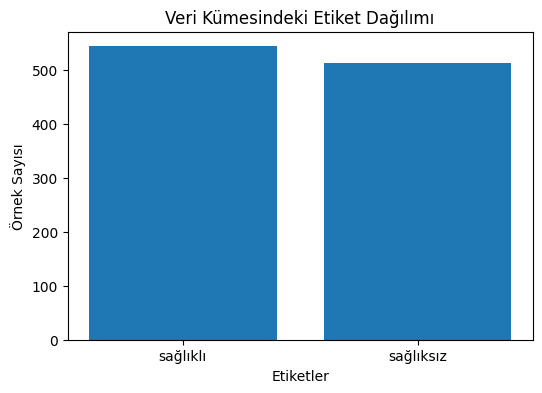

In [ ]:

# 5.1. Etiket dağılımını matplotlib ile görselleştirme
unique, counts = np.unique(y_num, return_counts=True)
plt.figure(figsize=(6,4))
plt.bar(unique, counts, tick_label=le.classes_)
plt.title('Veri Kümesindeki Etiket Dağılımı')
plt.xlabel('Etiketler')
plt.ylabel('Örnek Sayısı')
plt.show()

In [ ]:
# 6. Eğitim / validasyon / test kümesi ayır
X_train, X_temp, y_train_num, y_temp_num = train_test_split(
    X, y_num,
    test_size=0.30,
    stratify=y_num,
    random_state=random_seed
)
X_val, X_test, y_val_num, y_test_num = train_test_split(
    X_temp, y_temp_num,
    test_size=0.50,
    stratify=y_temp_num,
    random_state=random_seed
)

In [ ]:
# 7. One-hot encoding
y_train = to_categorical(y_train_num)
y_val   = to_categorical(y_val_num)
y_test  = to_categorical(y_test_num)


In [ ]:
# 8. DataGenerator’lar
train_datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator()

train_gen = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
val_gen   = test_datagen.flow(X_val,   y_val,   batch_size=batch_size, shuffle=False)
test_gen  = test_datagen.flow(X_test,  y_test,  batch_size=batch_size, shuffle=False)

In [ ]:

# 9. Kısaca küme boyutlarını yazdır
print(f"Train:      {X_train.shape[0]} örnek")
print(f"Validation: {X_val.shape[0]} örnek")
print(f"Test:       {X_test.shape[0]} örnek")

Train:      738 örnek
Validation: 158 örnek
Test:       159 örnek


In [ ]:
model = Sequential([
    # 1) İlk katman olarak açıkça bir Input tanımlıyoruz
    Input(shape=(*img_size, 3)),

    # 2) Ardından konvolüsyon ve havuzlama katmanları
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(),

    # 3) Çıkışı düzleştirip tam bağlı katmanlara geçiyoruz
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    # 4) Son sınıflandırma katmanı
    Dense(2, activation='softmax')
])

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    23,888,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,907,650 (91.20 MB)

 Trainable params: 23,907,650 (91.20 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 1) Callback’leri oluştur
es = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
mc = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True
)

In [ ]:

# 2) Eğitime başla
history = model.fit(
    train_gen,
    epochs=20,
    validation_data=val_gen,
    callbacks=[es, mc]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5498 - loss: 3.4795

24/24 ━━━━━━━━━━━━━━━━━━━━ 102s 4s/step - accuracy: 0.5532 - loss: 3.4203 - val_accuracy: 0.8544 - val_loss: 0.4296
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7863 - loss: 0.4823

24/24 ━━━━━━━━━━━━━━━━━━━━ 88s 4s/step - accuracy: 0.7867 - loss: 0.4812 - val_accuracy: 0.8608 - val_loss: 0.5112
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7817 - loss: 0.5023

24/24 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - accuracy: 0.7828 - loss: 0.5002 - val_accuracy: 0.9114 - val_loss: 0.2524
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.8675 - loss: 0.3203 - val_accuracy: 0.9051 - val_loss: 0.2638
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.8843 - loss: 0.3267 - val_accuracy: 0.9114 - val_loss: 0.2383
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 85s 4s/step - accuracy: 0.8801 - loss: 0.3377 - val_accuracy: 0.8671 - val_loss: 0.2935
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8619 - loss: 0.3123

24/24 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.8621 - loss: 0.3122 - val_accuracy: 0.9367 - val_loss: 0.2228
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.8769 - loss: 0.2928 - val_accuracy: 0.8291 - val_loss: 0.6449
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.8928 - loss: 0.3178 - val_accuracy: 0.8987 - val_loss: 0.3293
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 84s 3s/step - accuracy: 0.8917 - loss: 0.2829 - val_accuracy: 0.7595 - val_loss: 0.5707


In [ ]:
from tensorflow.keras.models import load_model
best = load_model('best_model.h5')

# Test kümesinde performans ölçümü
loss, acc = best.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.2%}")


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.8909 - loss: 0.2725
Test Loss: 0.2573, Test Accuracy: 90.57%


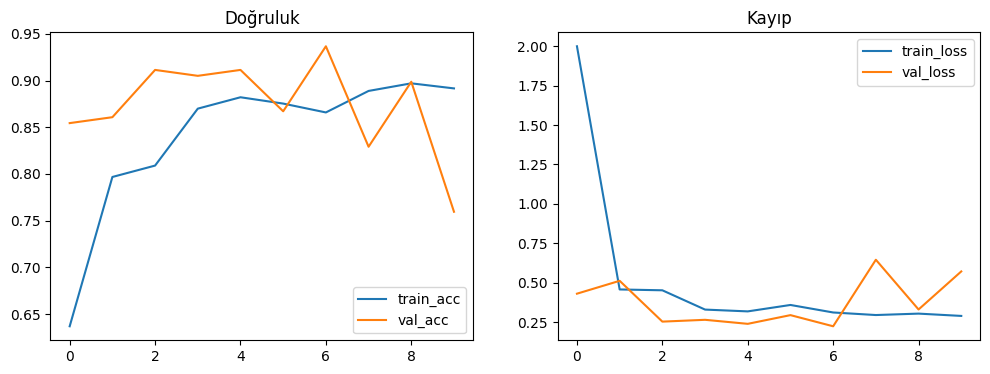

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend(); plt.title('Doğruluk')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Kayıp')
plt.show()


In [ ]:
from google.colab import files
files.download('best_model.h5')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import tensorflow as tf
from google.colab import files

model = tf.keras.models.load_model('best_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)


tflite_model = converter.convert()

# 4) .tflite dosyası olarak kaydet
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# 5) İndir
files.download('model.tflite')


Saved artifact at '/tmp/tmpkgtxb2kr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  133295391736272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133295391739728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133295391739152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133295391740688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133295391740496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133295391741456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133295391740304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133295391742800: TensorSpec(shape=(), dtype=tf.resource, name=None)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>